In [1]:
import pandas as pd
import numpy as np
import os
import neurokit2 as nk
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
import statsmodels.api as sm
import gc
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [20, 8]  # Bigger images

In [3]:
folder_path = "/Users/annapalatkina/Desktop/drive/participants"  

data_full = pd.DataFrame(columns=['Row', 'Timestamp', 'EDA', 'ECG', 'EventLabel', 'Participant'])


for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  
    if filename.endswith('.csv'): 
        data = pd.read_csv(file_path, comment='#',low_memory=False)
        if 'Channel 9 (EDA100C)' in data.columns:
            eda_column = 'Channel 9 (EDA100C)'
            ecg_column = 'Channel 13 (ECG100C)'
        elif 'Channel 9 (Raw)' in data.columns:
            eda_column = 'Channel 9 (Raw)'
            ecg_column = 'Channel 13 (Raw)'
        data = data[['Row', 'Timestamp', eda_column, ecg_column,'MarkerName','MarkerType']]
        start, end = data.query('MarkerName == "Experiment" and MarkerType == "S"').index.values[0], data.query('MarkerName == "Experiment" and MarkerType == "E"').index.values[0]
        data = data[start:end+1]
        data.reset_index(inplace=True, drop=True)
        markers =  list(data[data['MarkerName'].notna()].sort_values('Row').MarkerName.unique())
        markers.remove('Experiment')
        data['EventLabel'] = pd.Series(dtype='object')
        for i,m in enumerate(markers):
            start = data[(data.MarkerName == m) & (data.MarkerType == "S")].index.values[0]
            end = data[(data.MarkerName == m) & (data.MarkerType == "E")].index.values[0]
            data.loc[start:end, 'EventLabel'] = data.loc[start:end, 'EventLabel'].fillna(m)
        data['EventLabel'] = data['EventLabel'].fillna('Silence')
        data.dropna(subset=[eda_column, ecg_column], inplace=True)
        data.drop(columns=['MarkerName', 'MarkerType'], inplace=True)
        data['Participant'] = [filename.split('.')[0]] * len(data)
        data.rename(columns={eda_column: 'EDA', ecg_column:'ECG'}, inplace=True)
        data_full = pd.concat([data_full, data], ignore_index=True)
        del data
        gc.collect()
 
  
data_full

/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_32925/2183265743.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_full = pd.concat([data_full, data], ignore_index=True)


,Row,Timestamp,EDA,ECG,EventLabel,Participant
0,4507,10545.0005,1.191406,0.973206,Silence,I8L4N6G7
1,4508,10550.0005,1.192017,1.372375,Silence,I8L4N6G7
2,4509,10555.0005,1.191711,1.466064,Silence,I8L4N6G7
3,4514,10560.0005,1.192322,1.022949,Silence,I8L4N6G7
4,4515,10565.0005,1.192322,0.177612,Silence,I8L4N6G7
...,...,...,...,...,...,...
3230932,397469,933564.2909,1.839600,-0.037537,Silence,K4G7Y9O2
3230933,397471,933569.2909,1.841431,-0.045776,Silence,K4G7Y9O2
3230934,397472,933574.2909,1.839905,-0.041504,Silence,K4G7Y9O2
3230935,397473,933579.2909,1.840210,-0.043945,Silence,K4G7Y9O2


In [4]:
data_full.Participant.value_counts()

Participant
V9L0P2K7    180004
N7P5B8G0    180002
J6W7Q4H5    180001
G9K4W1Z0    180000
Z6A2W1E8    180000
M4H6R2W9    180000
X5Q0G4J2    180000
J4X1T0D2    180000
C1K4L9S8    179999
D0P7X9W6    179997
M7D3F5K4    179997
O4A0U8R1    179997
G2Y7J4Q1    179997
K4G7Y9O2    179996
L0S1Z2I3    179994
U6O5V2T9    178371
I8L4N6G7    178046
M0R6U5F9    174536
Name: count, dtype: int64

In [5]:
data_full.EventLabel.value_counts()

EventLabel
Silence         1093272
IntenseAudio     979597
CalmAudio        977847
InterimAudio     180221
Name: count, dtype: int64

# RMSSD + lin.reg

In [6]:
sampling_rate = 200

In [7]:

mask_negative = (data_full["EventLabel"] == "IntenseAudio")
mask_positive = (data_full["EventLabel"] == "CalmAudio")


In [8]:
def get_slope_for_condition(ecg_data_raw, segment_duration):
    
    ecg = nk.ecg_clean(ecg_data_raw, sampling_rate=sampling_rate)
    peaks, info = nk.ecg_peaks(ecg, sampling_rate=sampling_rate)
    r_peaks = info['ECG_R_Peaks']
    #segment_duration = 60  # For 1-minute segments (use 30 for 30-second segments)

    # Step 1: Convert R-peak indices to time (seconds)
    times = np.array(r_peaks) / sampling_rate

    # Step 2: Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(times) * 1000  # Difference in seconds, then convert to ms

    # Step 3: Segment the data
    total_duration = times[-1]  # Total experiment time in seconds
    num_segments = int(np.floor(total_duration / segment_duration))
    # print(total_duration, num_segments)

    rmssd_per_segment = []
    time_list = []

    for seg in range(num_segments):
        # Define the time window for this segment
        start_time = seg * segment_duration
        end_time = (seg + 1) * segment_duration
        
        # Find R-peaks within this time window
        mask = (times[:-1] >= start_time) & (times[:-1] < end_time)
        segment_rr = rr_intervals[mask]
        
        # Step 4: Calculate RMSSD for this segment
        successive_diffs = np.diff(segment_rr)
        squared_diffs = successive_diffs ** 2
        mean_squared_diffs = np.mean(squared_diffs)
        rmssd = np.sqrt(mean_squared_diffs)
        rmssd_per_segment.append(rmssd)
        time_list.append(end_time)
    
    # print(len(time_list), len(rmssd_per_segment))
    rmssd_df = pd.DataFrame({'Time': time_list, 'RMSSD': rmssd_per_segment})
    rmssd_df['Time_str'] = rmssd_df['Time'].apply(lambda x: str(timedelta(seconds=x)))

    X = sm.add_constant(time_list)
    model = sm.OLS(rmssd_per_segment, X).fit()
    slope = model.params[1]

    return slope

In [9]:
segment_duration = 30

positives = data_full[mask_positive]
negatives = data_full[mask_negative]

positives_slopes = [get_slope_for_condition(data.ECG, segment_duration) for participant_id, data in positives.groupby(by='Participant')]
negatives_slopes = [get_slope_for_condition(data.ECG, segment_duration) for participant_id, data in negatives.groupby(by='Participant')]


In [10]:
for participant_id, data in positives.groupby(by='Participant'):
    print(participant_id)

C1K4L9S8
D0P7X9W6
G2Y7J4Q1
G9K4W1Z0
I8L4N6G7
J4X1T0D2
J6W7Q4H5
K4G7Y9O2
L0S1Z2I3
M0R6U5F9
M4H6R2W9
M7D3F5K4
N7P5B8G0
O4A0U8R1
U6O5V2T9
V9L0P2K7
X5Q0G4J2
Z6A2W1E8


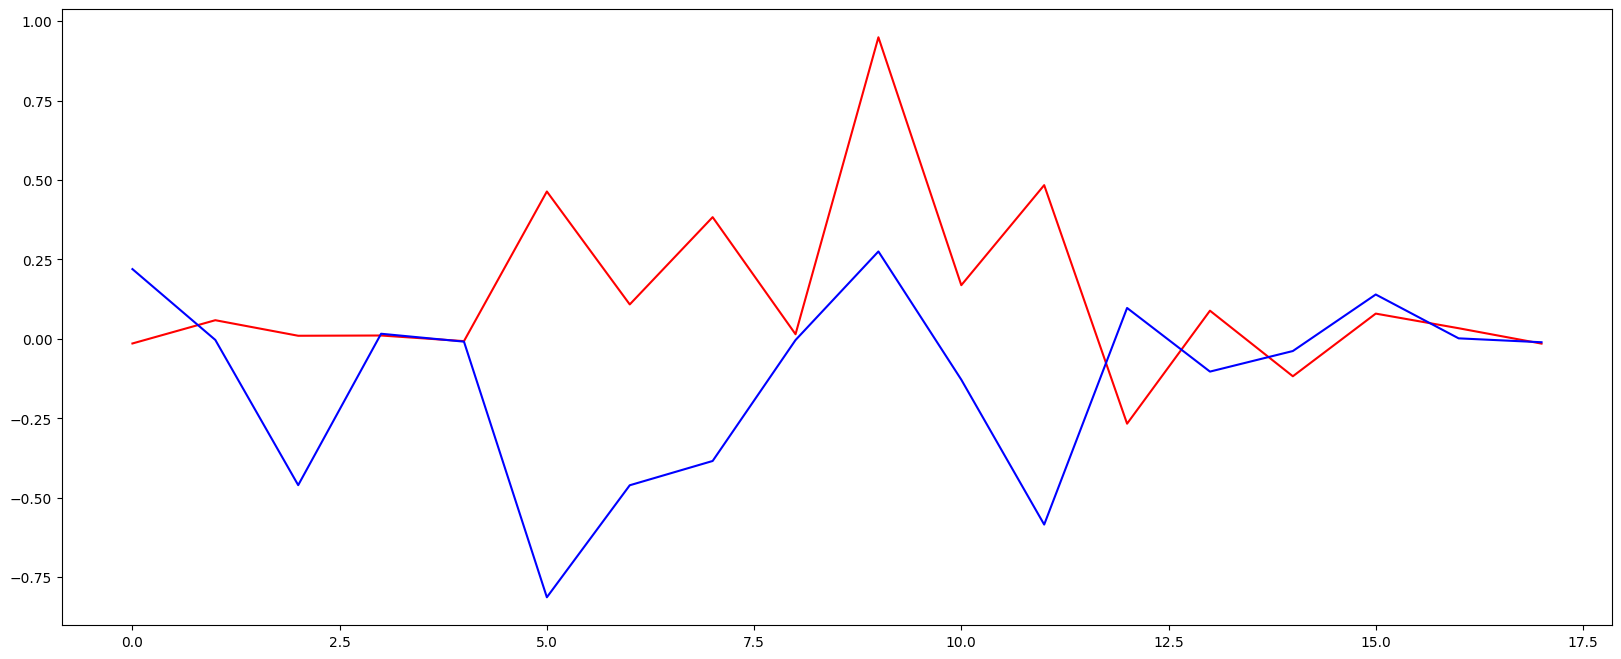

In [11]:
from numpy import *
import math
import matplotlib.pyplot as plt


plt.plot(positives_slopes, 'r') # plotting t, a separately 
plt.plot(negatives_slopes, 'b') # plotting t, b separately 

plt.show()

In [12]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt


np.random.seed(42)  # For reproducibility
n_participants = len(positives_slopes)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Positive': positives_slopes,
    'Negative': negatives_slopes
}
df = pd.DataFrame(data)

# Long format for repeated measures ANOVA
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='Slope')
ps = []

# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    ps.append(p >= 0.05)
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

print()

# 2. Choose and run the test
if all(ps):  # All normal
    print('Doing anova')
    # Repeated Measures ANOVA
    anova = pg.rm_anova(data=df_long, dv='Slope', within='Condition', subject='Participant')
    print("\nRepeated Measures ANOVA Results:")
    print(anova)
    if anova['p-unc'][0] < 0.05:
        print("Significant difference found (p < 0.05). Performing post-hoc tests...")
        # Post-hoc paired t-tests with Bonferroni correction
        conditions = df.columns[1:]
        for i in range(len(conditions)):
            for j in range(i + 1, len(conditions)):
                cond1, cond2 = conditions[i], conditions[j]
                t_stat, p_val = stats.ttest_rel(df[cond1], df[cond2])
                p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2  # Bonferroni
                print(f"Paired t-test {cond1} vs {cond2}: t={t_stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")
else:
    print('Doing Friedman')
    # Friedman Test (non-parametric)
    stat, p = stats.friedmanchisquare( df['Positive'], df['Negative'])
    print("\nFriedman Test Results:")
    print(f"Chi-square={stat:.3f}, p={p:.3f}")
    if p < 0.05:
        print("Significant difference found (p < 0.05). Performing post-hoc Wilcoxon tests...")
        # Post-hoc Wilcoxon Signed-Rank tests with Bonferroni correction
        conditions = df.columns[1:]
        for i in range(len(conditions)):
            for j in range(i + 1, len(conditions)):
                cond1, cond2 = conditions[i], conditions[j]
                stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
                p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2
                print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")

# Optional: Visualize the data
plt.boxplot([df['Positive'], df['Negative']], tick_labels=[ 'Positive', 'Negative'])
plt.title('Boxplot of the RMSSD trend slopes for Different Conditions', fontsize=18)
plt.ylabel('Slope', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


Shapiro-Wilk test for Positive: statistic=0.827, p=0.004
  Positive is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative: statistic=0.894, p=0.046
  Negative is not normally distributed (p < 0.05)

Doing Friedman


ValueError: At least 3 sets of samples must be given for Friedman test, got 2.

In [14]:
from scipy.stats import friedmanchisquare
res = friedmanchisquare(baselines_slopes, negatives_slopes, positives_slopes)
res.statistic, res.pvalue

(np.float64(2.470588235294116), np.float64(0.29074923530998636))

In [66]:
# Due to the assumption that the test statistic has a chi squared distribution, the p-value is only reliable for n > 10 and more than 6 repeated samples.

In [13]:
from scipy.stats import wilcoxon
res = wilcoxon(negatives_slopes, positives_slopes)
res.statistic, res.pvalue

(np.float64(41.0), np.float64(0.05385589599609375))

In [15]:
from scipy.stats import wilcoxon
# compare samples
stat, p = wilcoxon( df['Positive'], df['Negative'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=41.000, p=0.098
Same distribution (fail to reject H0)


# Visualisations

In [92]:
for participant_id, data in positives.groupby(by='Participant'):
    signals, info = nk.bio_process(data.ECG, sampling_rate=200)
    hr = nk.hrv(signals, sampling_rate=200)
    print(participant_id)
    print(hr.HRV_MeanNN) # The mean of the RR intervals.
    print(hr.HRV_SDNN) # the standard deviation of the RR intervals.
    print(hr.HRV_RMSSD)
    print()


C1K4L9S8
0    961.370107
Name: HRV_MeanNN, dtype: float64
0    45.400893
Name: HRV_SDNN, dtype: float64
0    25.170845
Name: HRV_RMSSD, dtype: float64

D0P7X9W6
0    993.4375
Name: HRV_MeanNN, dtype: float64
0    82.456764
Name: HRV_SDNN, dtype: float64
0    68.260544
Name: HRV_RMSSD, dtype: float64

G9K4W1Z0
0    648.561151
Name: HRV_MeanNN, dtype: float64
0    28.602745
Name: HRV_SDNN, dtype: float64
0    13.736882
Name: HRV_RMSSD, dtype: float64

I8L4N6G7
0    885.424837
Name: HRV_MeanNN, dtype: float64
0    33.222784
Name: HRV_SDNN, dtype: float64
0    32.431517
Name: HRV_RMSSD, dtype: float64

J4X1T0D2
0    881.026059
Name: HRV_MeanNN, dtype: float64
0    46.375203
Name: HRV_SDNN, dtype: float64
0    39.679064
Name: HRV_RMSSD, dtype: float64

J6W7Q4H5
0    753.746518
Name: HRV_MeanNN, dtype: float64
0    56.266175
Name: HRV_SDNN, dtype: float64
0    48.035427
Name: HRV_RMSSD, dtype: float64

K4G7Y9O2
0    575.127389
Name: HRV_MeanNN, dtype: float64
0    21.200279
Name: HRV_SDNN, d

In [75]:
ecg = nk.ecg_clean(data_full.ECG, sampling_rate=sampling_rate)
ecg

array([-0.09040538, -0.01114776, -0.05466878, ..., -0.04427501,
       -0.04055762, -0.03399265], shape=(3050940,))

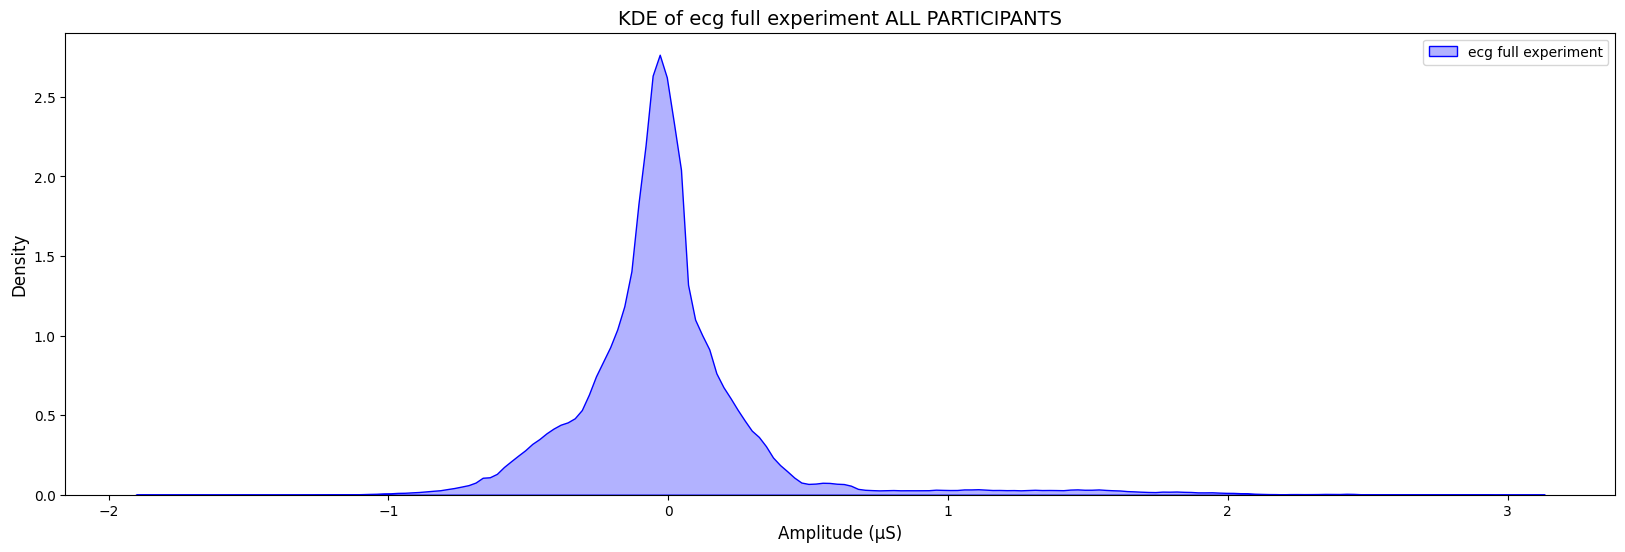

In [95]:
plt.figure(figsize=(20, 6))
sns.kdeplot(ecg, label='ecg full experiment', color='blue', fill=True, alpha=0.3, bw_adjust=.15)
plt.title('KDE of ecg full experiment ALL PARTICIPANTS', fontsize=14)
plt.xlabel('Amplitude (μS)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

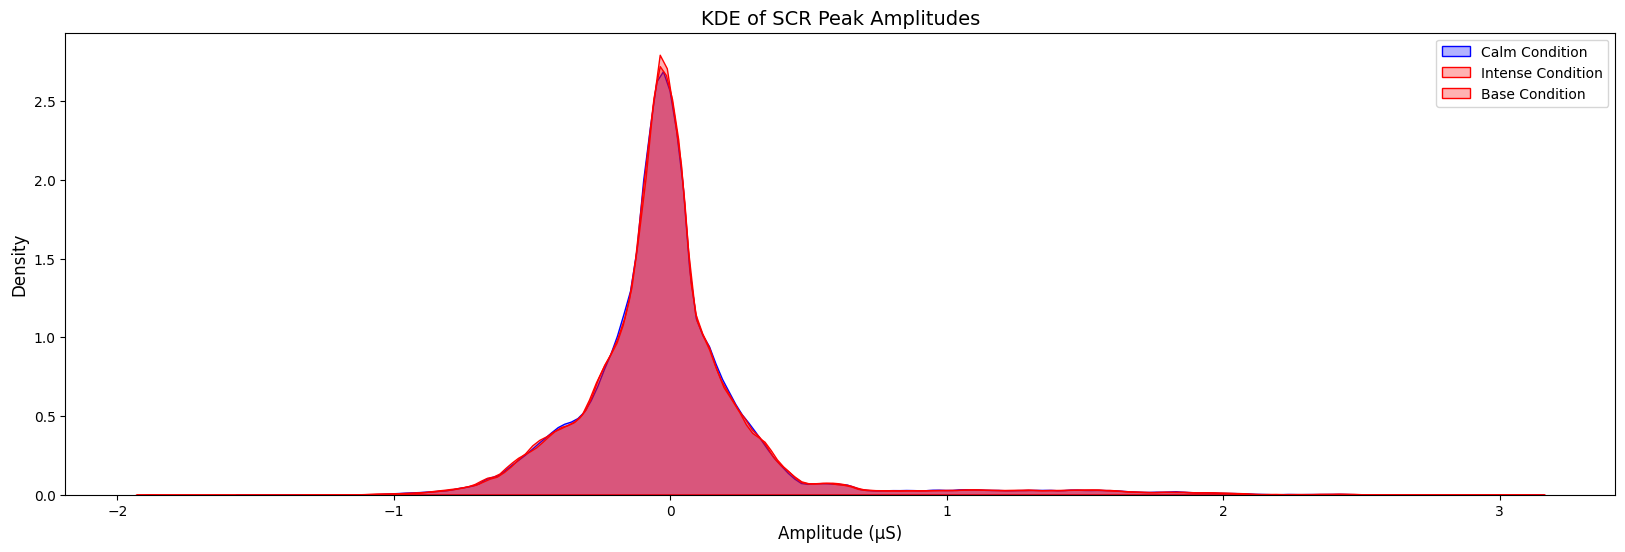

In [77]:
ecg_pos = nk.ecg_clean(data_full.query('EventLabel == "CalmAudio"').ECG, sampling_rate=sampling_rate)
ecg_neg = nk.ecg_clean(data_full.query('EventLabel == "IntenseAudio"').ECG, sampling_rate=sampling_rate)
ecg_bas = nk.ecg_clean(data_full.query('EventLabel == "Silence"').ECG, sampling_rate=sampling_rate)

plt.figure(figsize=(20, 6))
sns.kdeplot(ecg_pos, label='Calm Condition', color='blue', fill=True, alpha=0.3,  bw_adjust=.55)
sns.kdeplot(ecg_neg, label='Intense Condition', color='red', fill=True, alpha=0.3, bw_adjust=.55)
sns.kdeplot(ecg_bas, label='Base Condition', color='red', fill=True, alpha=0.3, bw_adjust=.55)
plt.title('KDE of SCR Peak Amplitudes', fontsize=14)
plt.xlabel('Amplitude (μS)', fontsize=12)
plt.ylabel('Density', fontsize=12)
#plt.xlim(0, 2)  # Set x-axis limit based on data range
plt.legend()
plt.show()

# old + kde

In [144]:
data = data_full.query('Participant == "C1K4L9S8"')
data

,Row,Timestamp,EDA,ECG,EventLabel,Participant
2870939,1609,5139.4775,1.437073,-0.871582,Silence,C1K4L9S8
2870940,1610,5144.4775,1.437073,-0.826111,Silence,C1K4L9S8
2870941,1611,5149.4775,1.436768,-0.754395,Silence,C1K4L9S8
2870942,1612,5154.4775,1.437073,-0.677185,Silence,C1K4L9S8
2870943,1614,5159.4775,1.437378,-0.617676,Silence,C1K4L9S8
...,...,...,...,...,...,...
3050933,348622,905109.4775,1.686707,-0.785217,Silence,C1K4L9S8
3050934,348623,905114.4775,1.686401,-0.759583,Silence,C1K4L9S8
3050935,348624,905119.4775,1.685791,-0.717163,Silence,C1K4L9S8
3050936,348625,905124.4775,1.686096,-0.657349,Silence,C1K4L9S8


In [145]:
ecg = nk.ecg_clean(data["ECG"], sampling_rate=sampling_rate)
peaks, info = nk.ecg_peaks(ecg, sampling_rate=sampling_rate)
hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_rate, show=False)
hrv_time.HRV_RMSSD

0    52.091417
Name: HRV_RMSSD, dtype: float64

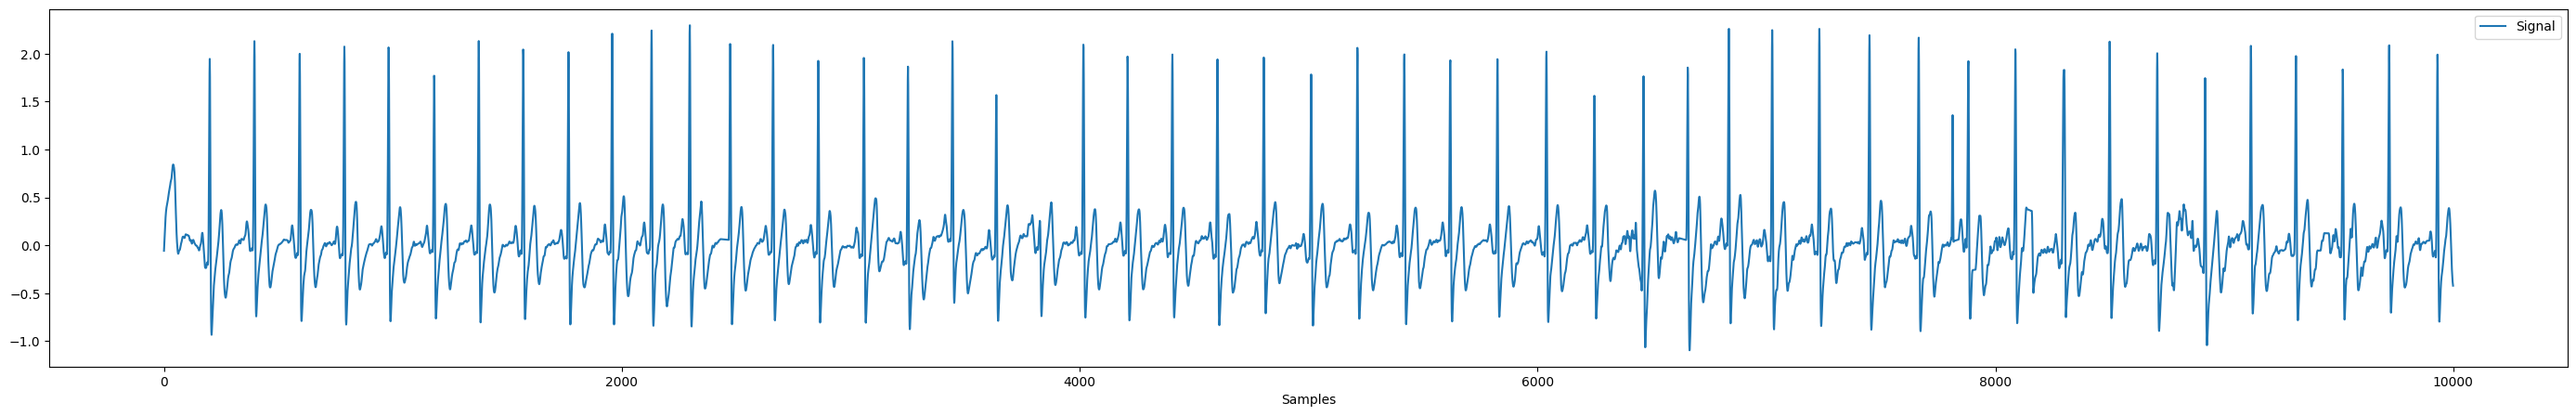

In [146]:
nk.signal_plot(ecg[:10000])

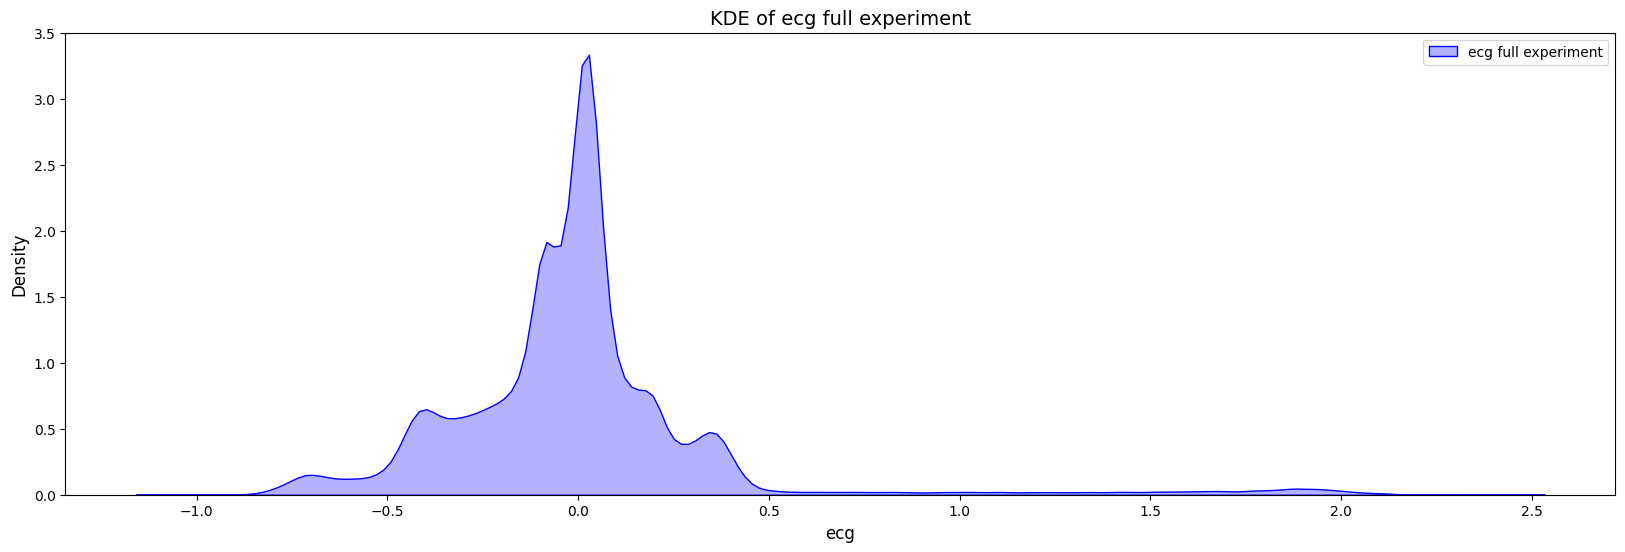

In [147]:
plt.figure(figsize=(20, 6))
sns.kdeplot(ecg, label='ecg full experiment', color='blue', fill=True, alpha=0.3, bw_adjust=.65)
plt.title('KDE of ecg full experiment', fontsize=14)
plt.xlabel('ecg', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

In [149]:
sampling_rate = 200
r_peaks = info['ECG_R_Peaks']
segment_duration = 30  # For 1-minute segments (use 30 for 30-second segments)

# Step 1: Convert R-peak indices to time (seconds)
times = np.array(r_peaks) / sampling_rate

# Step 2: Calculate RR intervals (in milliseconds)
rr_intervals = np.diff(times) * 1000  # Difference in seconds, then convert to ms

# Step 3: Segment the data
total_duration = times[-1]  # Total experiment time in seconds
num_segments = int(np.ceil(total_duration / segment_duration))
print(total_duration, num_segments)

rmssd_per_segment = []
time_list = []

for seg in range(num_segments):
    # Define the time window for this segment
    start_time = seg * segment_duration
    end_time = (seg + 1) * segment_duration
    
    # Find R-peaks within this time window
    mask = (times[:-1] >= start_time) & (times[:-1] < end_time)
    segment_rr = rr_intervals[mask]
    
    successive_diffs = np.diff(segment_rr)
    squared_diffs = successive_diffs ** 2
    mean_squared_diffs = np.mean(squared_diffs)
    rmssd = np.sqrt(mean_squared_diffs)
    rmssd_per_segment.append(rmssd)
    time_list.append(end_time)

# Output RMSSD for each segment
for i, rmssd in enumerate(rmssd_per_segment):
    print(f"Segment {i+1} ({i*segment_duration}-{(i+1)*segment_duration}s): RMSSD = {rmssd:.2f} ms")

899.935 30
Segment 1 (0-30s): RMSSD = 30.64 ms
Segment 2 (30-60s): RMSSD = 163.35 ms
Segment 3 (60-90s): RMSSD = 36.26 ms
Segment 4 (90-120s): RMSSD = 17.85 ms
Segment 5 (120-150s): RMSSD = 20.49 ms
Segment 6 (150-180s): RMSSD = 19.51 ms
Segment 7 (180-210s): RMSSD = 22.36 ms
Segment 8 (210-240s): RMSSD = 24.67 ms
Segment 9 (240-270s): RMSSD = 26.29 ms
Segment 10 (270-300s): RMSSD = 31.12 ms
Segment 11 (300-330s): RMSSD = 29.00 ms
Segment 12 (330-360s): RMSSD = 22.72 ms
Segment 13 (360-390s): RMSSD = 23.70 ms
Segment 14 (390-420s): RMSSD = 28.10 ms
Segment 15 (420-450s): RMSSD = 12.92 ms
Segment 16 (450-480s): RMSSD = 134.64 ms
Segment 17 (480-510s): RMSSD = 22.84 ms
Segment 18 (510-540s): RMSSD = 22.54 ms
Segment 19 (540-570s): RMSSD = 20.94 ms
Segment 20 (570-600s): RMSSD = 28.98 ms
Segment 21 (600-630s): RMSSD = 26.65 ms
Segment 22 (630-660s): RMSSD = 21.93 ms
Segment 23 (660-690s): RMSSD = 35.42 ms
Segment 24 (690-720s): RMSSD = 22.48 ms
Segment 25 (720-750s): RMSSD = 23.79 ms
Segm

In [150]:
ecg = nk.ecg_clean(data["ECG"], sampling_rate=sampling_rate)
peaks, info = nk.ecg_peaks(ecg, sampling_rate=sampling_rate)
hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_rate, show=False)
hrv_time.HRV_RMSSD

0    52.091417
Name: HRV_RMSSD, dtype: float64

In [ ]:
rmssd_df = pd.DataFrame({'Time': time_list, 'RMSSD': rmssd_per_segment})
rmssd_df['Time_str'] = rmssd_df['Time'].apply(lambda x: str(timedelta(seconds=x)))

# Step 5: Fit linear regression to RMSSD over time
valid = rmssd_df.dropna()
if len(valid) > 1:
    X = sm.add_constant(valid['Time'])
    model = sm.OLS(valid['RMSSD'], X).fit()
    slope = model.params[1]
    intercept = model.params[0]
    time_range = np.linspace(min(valid['Time']), max(valid['Time']), 100)
    rmssd_fit = intercept + slope * time_range
else:
    slope, intercept = np.nan, np.nan
    rmssd_fit = np.nan

In [58]:
rmssd_df

,Time,RMSSD,Time_str
0,60,21.918152,0:01:00
1,120,22.322876,0:02:00
2,180,64.704624,0:03:00
3,240,24.784788,0:04:00
4,300,22.863230,0:05:00
5,360,65.689661,0:06:00
6,420,19.148542,0:07:00
7,480,60.292598,0:08:00
8,540,18.973666,0:09:00
9,600,28.295748,0:10:00


In [59]:
slope

np.float64(0.015251436160278992)

# OLD

In [38]:
rpeaks_indices = info['ECG_R_Peaks']
rpeak_times = rpeaks_indices / sampling_rate
T = len(data.ECG) / sampling_rate 
window_size = 60  
window_starts = np.arange(0, T, window_size)

rmssd_list = []
time_list = []
for window_start in window_starts:
    t_start = window_start
    t_end = window_start + window_size
    mask = (rpeak_times >= t_start) & (rpeak_times < t_end)
    selected_rpeaks = rpeak_times[mask]
    if len(selected_rpeaks) >= 2:
        rr = np.diff(selected_rpeaks)
        if len(rr) >= 2:
            dd = np.diff(rr)
            rmssd = np.sqrt(np.mean(dd**2))
        else:
            rmssd = np.nan
    else:
        rmssd = np.nan
    time_list.append(t_start)
    rmssd_list.append(rmssd)

rmssd_df = pd.DataFrame({'Time': time_list, 'RMSSD': rmssd_list})
rmssd_df['Time_str'] = rmssd_df['Time'].apply(lambda x: str(timedelta(seconds=x)))
rmssd_df

,Time,RMSSD,Time_str
0,0.0,0.086692,0:00:00
1,60.0,0.038310,0:01:00
2,120.0,0.033620,0:02:00
3,180.0,0.033461,0:03:00
4,240.0,0.033432,0:04:00
5,300.0,0.031746,0:05:00
6,360.0,0.032404,0:06:00
7,420.0,0.032972,0:07:00
8,480.0,0.080135,0:08:00
9,540.0,0.033852,0:09:00


Overall HRV metrics:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  898.918099  41.063696    25.57233   32.525715   22.971125   35.379341   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0   19.147225   37.979802  33.165485  33.182127  ...       60.0     1.238145   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        865.0        935.0   7.280081  64.914055      775.0     1010.0   

    HRV_HTI  HRV_TINN  
0  9.419048   140.625  

[1 rows x 25 columns]


/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_43632/2096647733.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model.params[1]
/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_43632/2096647733.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = model.params[0]


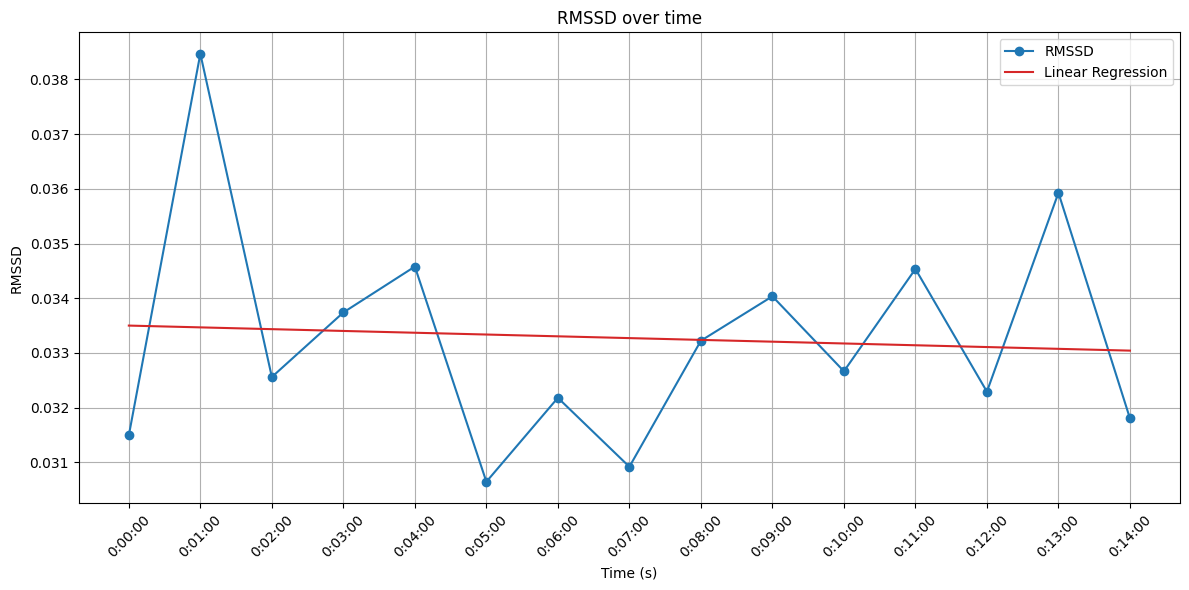

In [24]:
data = data_full[data_full['Participant'] == 'I8L4N6G7']

sampling_rate = 200  # Adjust based on your dataset

# Step 2: Process the entire ECG signal
signals, info = nk.ecg_process(data.ECG, sampling_rate=sampling_rate)
rpeaks_indices = info['ECG_R_Peaks']
rpeak_times = rpeaks_indices / sampling_rate

# Step 3: Compute overall HRV metrics
hrv_overall = nk.hrv_time(rpeaks_indices, sampling_rate=sampling_rate, show= False)
print("Overall HRV metrics:")
print(hrv_overall)

# Step 4: Compute RMSSD for each one-minute window
T = len(data.ECG) / sampling_rate  # Total duration in seconds
window_size = 60  # One-minute windows
window_starts = np.arange(0, T, window_size)

rmssd_list = []
time_list = []
for window_start in window_starts:
    t_start = window_start
    t_end = window_start + window_size
    mask = (rpeak_times >= t_start) & (rpeak_times < t_end)
    selected_rpeaks = rpeak_times[mask]
    if len(selected_rpeaks) >= 2:
        rr = np.diff(selected_rpeaks)
        if len(rr) >= 2:
            dd = np.diff(rr)
            rmssd = np.sqrt(np.mean(dd**2))
        else:
            rmssd = np.nan
    else:
        rmssd = np.nan
    time_list.append(t_start)
    rmssd_list.append(rmssd)

rmssd_df = pd.DataFrame({'Time': time_list, 'RMSSD': rmssd_list})
rmssd_df['Time_str'] = rmssd_df['Time'].apply(lambda x: str(timedelta(seconds=x)))

# Step 5: Fit linear regression to RMSSD over time
valid = rmssd_df.dropna()
if len(valid) > 1:
    X = sm.add_constant(valid['Time'])
    model = sm.OLS(valid['RMSSD'], X).fit()
    slope = model.params[1]
    intercept = model.params[0]
    time_range = np.linspace(min(valid['Time']), max(valid['Time']), 100)
    rmssd_fit = intercept + slope * time_range
else:
    slope, intercept = np.nan, np.nan
    rmssd_fit = np.nan

# Step 6: Visualize RMSSD over time with linear regression
plt.figure(figsize=(12, 6))
plt.plot(rmssd_df['Time'], rmssd_df['RMSSD'], marker='o', label='RMSSD', color='#1f77b4')
if not np.isnan(rmssd_fit).any():
    plt.plot(time_range, rmssd_fit, color='#d62728', label='Linear Regression')
plt.xlabel('Time (s)')
plt.ylabel('RMSSD')
plt.title('RMSSD over time')
plt.legend()
plt.grid(True)
plt.xticks(rmssd_df['Time'], rmssd_df['Time_str'], rotation=45)
plt.tight_layout()
plt.show()
# a negative slope (k < 0) indicates increasing stress, and a positive slope (k > 0) indicates decreasing stress.

In [ ]:
# smaller chunks 30 sec
# 2 sloped for each (calm and intense)
# p values based on 

/Users/annapalatkina/Desktop/drive/.venv/lib/python3.10/site-packages/neurokit2/ecg/ecg_plot.py:70: NeuroKitWarning: 'info' dict not provided. Some information might be missing. Sampling rate will be set to 1000 Hz.
  warn(


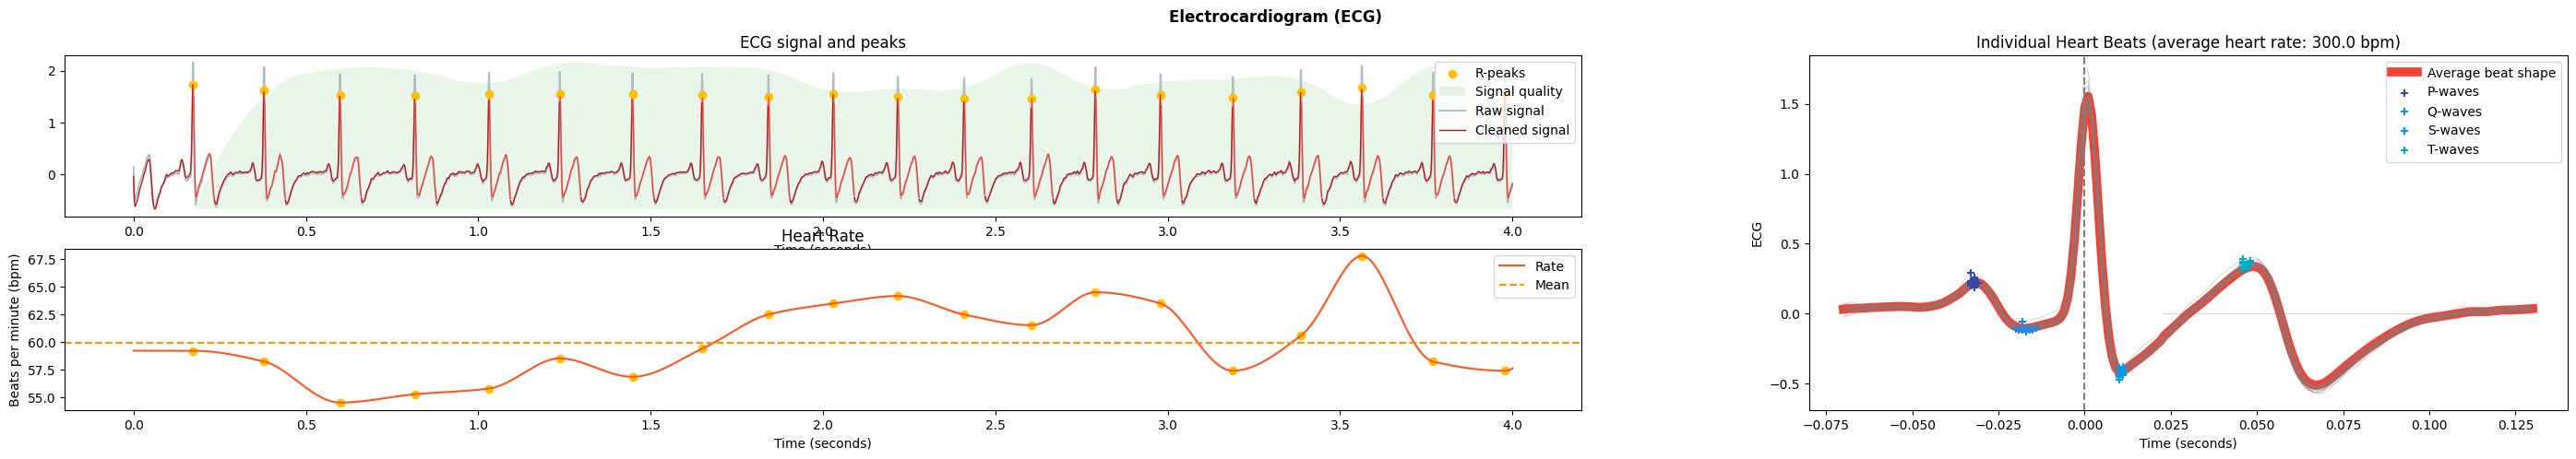

In [ ]:
# Step 7: Visualize a sample ECG segment (first 10 seconds)
signals_first10 = signals.iloc[:int(20 * sampling_rate)]
nk.ecg_plot(signals_first10)
plt.show()